In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "24" 

import sys
sys.path.insert(0, "/data/rowe/python/ifort/") #pre-compiled Fortran library for python.

import numpy as np
import matplotlib
import matplotlib.pyplot  as plt

#Import module
import transitfit5 as tf #import transitfit5 modules
import tfit5 as tfit5 #Fortran-low-level modules

import math

from scipy.stats import binned_statistic #for binned data.

from tqdm.notebook import trange

import corner

#Modules for timing (not needed for production)
import time

In [2]:
class phot_class:
    def __init__(self):
        #initialize arrays
        self.wavelength=[] #wavelength of observation (should be a single number)
        self.time=[]       #time-stamps array -- mid-exposure time (days)
        self.flux=[]       #observed flux array 
        self.ferr=[]       #error in flux array
        self.itime=[]      #integration time (seconds)
        
class psg_class:
    def __init__(self):
        #initialize arrays
        self.wavelength=[] #wavelength of observation array
        self.flux=[]       #observed transit-depth due to atmosphere (ppm)
        self.ferr=[]       #predicted noise (ppm)
        
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1 #array[idx-1]
    else:
        return idx #array[idx]
        
def read_model(filename):
    '''Reads in simple space delimited textfile.
    '''
    
    data=[]
    f=open(filename)
    icount=-1
    for line in f:
        line = line.strip()
        columns = line.split() #break into columns
        icount+=1
        if(icount > 0)&(columns[0]!='#'):  #skip header info
            data.append([float(i) for i in columns])
            #data.append(columns)
    f.close()
    
    return data

class sptransit_model_class(object):
    def __init__(self):
        self.wavelength =[]     #Wavelength of each observation 
        
        self.rhostar=[]         #mean stellar density
        self.ld1=[]             #limb-darkening. set ld1=ld2=0 and ld3=q1 and ld4=q2
        self.ld2=[]  
        self.ld3=[]  
        self.ld4=[]  
        self.dilution=[]        #stellar dilution 0=none, 0.99 means 99% of light from other source
        self.zeropoint=[]       #out of transit baseline
        
        self.nplanet=1          #number of planets
        self.t0=[]              #center of transit time
        self.period=[]          #orbital period
        self.b=[]               #impact parameter
        self.rprs=[]            #scale planet radius 
        self.sqrt_e_cosw=[]     #sqrt(e)cos(w)
        self.sqrt_e_sinw=[]     #sqrt(e)cos(w)
        self.eclipse_depth=[]   #Secondard eclipse depth (ppm)
        self.ellipsoidal=[]     #amplitude of ellipsoidal variations (ppm)
        self.phasecurve=[]      #amplitude of reflected/emission phase curve (ppm) - Lambertian
        
        self.error_scale=[]     #scale to apply to photometric errors
        self.amplitude_scale=[] #GP Kernel Amplitude (default is Matern 3/2)
        self.length_scale=[]    #GP length scale (default is Matern 3/2)
        
        self.ntt=[]             #parameters for TTVs ntt=number of transit times
        self.tobs=[]            #observed centre of transit times
        self.omc=[]             #O-C values for eachtransit

class sptransit_model_parameters(sptransit_model_class):
    def __init__(self, num):
        sptransit_model_class.__init__(self)
        nwav=len(num[0])
        
        #Wavelength for each dataset
        zpt=[]
        for p in num[0]:
            self.wavelength.append(p.wavelength)
            zpt.append(np.median(p.flux))
        zpt=np.array(zpt)
            
        #Star Parameters
        self.rhostar=[np.ones(1),'bolometric','fit',np.array([1.0e-4,1000])]     
        self.ld1=[np.zeros(nwav),'chromatic','fixed',np.array([-1,1])]  
        self.ld2=[np.zeros(nwav),'chromatic','fixed',np.array([-1,1])]  
        self.ld3=[np.ones(nwav)*0.5,'chromatic','fit',np.array([0,1])]  
        self.ld4=[np.ones(nwav)*0.5,'chromatic','fit',np.array([0,1])]  
        self.dilution=[np.zeros(nwav),'chromatic','fixed',np.array([0,1])]
        self.zeropoint=[zpt,'chromatic','fit',np.array([0,1.0e9])]
        
        #Planet Parameters
        nplanet=num[1]
        self.nplanet=num[1]*1
        for i in range(nplanet):
            self.t0.append([np.ones(1),'bolometric','fit',np.array([0,2])])
            self.period.append([np.ones(1),'bolometric','fit',np.array([0,2])])
            self.b.append([np.ones(1)*0.5,'bolometric','fit',np.array([0,2])])
            self.rprs.append([np.ones(nwav)*0.01,'chromatic','fit',np.array([0,1])])
            self.sqrt_e_cosw.append([np.zeros(1),'bolometric','fixed',np.array([-1,1])])
            self.sqrt_e_sinw.append([np.zeros(1),'bolometric','fixed',np.array([-1,1])])
            self.eclipse_depth.append([np.zeros(nwav),'chromatic','fixed',np.array([0,1.0e4])])
            self.ellipsoidal.append([np.zeros(nwav),'chromatic','fixed',np.array([0,1.0e4])])
            self.phasecurve.append([np.zeros(nwav),'chromatic','fixed',np.array([0,1.0e4])])
            
        #Error model
        self.error_scale=[np.ones(1)*1.0,'bolometric','fit',np.array([0,2])]
        self.amplitude_scale=[np.ones(nwav)*1.0,'chromatic','fixed',np.array([0,2000])]
        self.length_scale=[np.ones(nwav)*1.0,'chromatic','fixed',np.array([0,1])]
        
        self.ntt=0
        self.tobs=0
        self.omc=0
        
        
def get_fitted_parameters(tpars):
    
    x=[]
    
    if tpars.rhostar[2]=='fit':
        for p in tpars.rhostar[0]:
            x.append(p)
            
    if tpars.ld1[2]=='fit':
        for p in tpars.ld1[0]:
            x.append(p)
            
    if tpars.ld2[2]=='fit':
        for p in tpars.ld2[0]:
            x.append(p)
            
    if tpars.ld3[2]=='fit':
        for p in tpars.ld3[0]:
            x.append(p)
            
    if tpars.ld4[2]=='fit':
        for p in tpars.ld4[0]:
            x.append(p)
            
    if tpars.dilution[2]=='fit':
        for p in tpars.dilution[0]:
            x.append(p)
            
    if tpars.zeropoint[2]=='fit':
        for p in tpars.zeropoint[0]:
            x.append(p)
            
    for i in range(tpars.nplanet):
            
        if tpars.t0[i][2]=='fit':
            for p in tpars.t0[i][0]:
                x.append(p)
                
        if tpars.period[i][2]=='fit':
            for p in tpars.period[i][0]:
                x.append(p)
                
        if tpars.b[i][2]=='fit':
            for p in tpars.b[i][0]:
                x.append(p)
                
        if tpars.rprs[i][2]=='fit':
            for p in tpars.rprs[i][0]:
                x.append(p)
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            for p in tpars.sqrt_e_cosw[i][0]:
                x.append(p)
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            for p in tpars.sqrt_e_sinw[i][0]:
                x.append(p)
        
        if tpars.eclipse_depth[i][2]=='fit':
            for p in tpars.eclipse_depth[i][0]:
                x.append(p)
        
        if tpars.ellipsoidal[i][2]=='fit':
            for p in tpars.ellipsoidal[i][0]:
                x.append(p)
                
        if tpars.phasecurve[i][2]=='fit':
            for p in tpars.phasecurve[i][0]:
                x.append(p)
                
    if tpars.error_scale[2]=='fit':
        for p in tpars.error_scale[0]:
            x.append(p)
            
    if tpars.amplitude_scale[2]=='fit':
        for p in tpars.amplitude_scale[0]:
            x.append(p)
            
    if tpars.length_scale[2]=='fit':
        for p in tpars.length_scale[0]:
            x.append(p)
        
    x=np.array(x)
    
    return x

def get_all_parameters(tpars,photospectra):
    
    
    nhp=3 #potential number of hyper-parameters
    
    npars=8+10*tpars.nplanet+nhp
    nwav=len(photospectra)
    
    sol=np.zeros([npars,nwav])
    
    if tpars.rhostar[1]=='bolometric':
        sol[0][:]=np.ones(nwav)*tpars.rhostar[0][0]
    else:
        sol[0][:]=tpars.rhostar[0]
        
    if tpars.ld1[1]=='bolometric':
        sol[1][:]=np.ones(nwav)*tpars.ld1[0][0]
    else:
        sol[1][:]=tpars.ld1[0]
        
    if tpars.ld2[1]=='bolometric':
        sol[2][:]=np.ones(nwav)*tpars.ld2[0][0]
    else:
        sol[2][:]=tpars.ld2[0]
        
    if tpars.ld3[1]=='bolometric':
        sol[3][:]=np.ones(nwav)*tpars.ld3[0][0]
    else:
        sol[3][:]=tpars.ld3[0]
        
    if tpars.ld4[1]=='bolometric':
        sol[4][:]=np.ones(nwav)*tpars.ld4[0][0]
    else:
        sol[4][:]=tpars.ld4[0]
        
    if tpars.dilution[1]=='bolometric':
        sol[5][:]=np.ones(nwav)*tpars.dilution[0][0]
    else:
        sol[5][:]=tpars.dilution[0]
        
    if tpars.zeropoint[1]=='bolometric':
        sol[7][:]=np.ones(nwav)*tpars.zeropoint[0][0]
    else:
        sol[7][:]=tpars.zeropoint[0]
        
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][1]=='bolometric':
            sol[8+nc][:]=np.ones(nwav)*tpars.t0[i][0][0]
        else:
            sol[8+nc][:]=tpars.t0[i][0]
            
        if tpars.period[i][1]=='bolometric':
            sol[9+nc][:]=np.ones(nwav)*tpars.period[i][0][0]
        else:
            sol[9+nc][:]=tpars.period[i][0]
            
        if tpars.b[i][1]=='bolometric':
            sol[10+nc][:]=np.ones(nwav)*tpars.b[i][0][0]
        else:
            sol[10+nc][:]=tpars.b[i][0]
            
        if tpars.rprs[i][1]=='bolometric':
            sol[11+nc][:]=np.ones(nwav)*tpars.rprs[i][0][0]
        else:
            sol[11+nc][:]=tpars.rprs[i][0]
            
        if tpars.sqrt_e_cosw[i][1]=='bolometric':
            sol[12+nc][:]=np.ones(nwav)*tpars.sqrt_e_cosw[i][0][0]
        else:
            sol[12+nc][:]=tpars.sqrt_e_cosw[i][0]
            
        if tpars.sqrt_e_sinw[i][1]=='bolometric':
            sol[13+nc][:]=np.ones(nwav)*tpars.sqrt_e_sinw[i][0][0]
        else:
            sol[13+nc][:]=tpars.sqrt_e_sinw[i][0]
            
        if tpars.eclipse_depth[i][1]=='bolometric':
            sol[15+nc][:]=np.ones(nwav)*tpars.eclipse_depth[i][0][0]
        else:
            sol[15+nc][:]=tpars.eclipse_depth[i][0]
            
        if tpars.ellipsoidal[i][1]=='bolometric':
            sol[16+nc][:]=np.ones(nwav)*tpars.ellipsoidal[i][0][0]
        else:
            sol[16+nc][:]=tpars.ellipsoidal[i][0]
        
        if tpars.phasecurve[i][1]=='bolometric':
            sol[17+nc][:]=np.ones(nwav)*tpars.phasecurve[i][0][0]
        else:
            sol[17+nc][:]=tpars.phasecurve[i][0]
    
    if tpars.error_scale[2]=='fit':
        if tpars.error_scale[1]=='bolometric':
            sol[npars-3][:]=np.ones(nwav)*tpars.error_scale[0][0]
        else:
            sol[npars-3][:]=tpars.error_scale[0]
            
    if tpars.amplitude_scale[2]=='fit':
        if tpars.amplitude_scale[1]=='bolometric':
            sol[npars-2][:]=np.ones(nwav)*tpars.amplitude_scale[0][0]
        else:
            sol[npars-2][:]=tpars.amplitude_scale[0]
            
    if tpars.length_scale[2]=='fit':
        if tpars.length_scale[1]=='bolometric':
            sol[npars-2][:]=np.ones(nwav)*tpars.length_scale[0][0]
        else:
            sol[npars-2][:]=tpars.length_scale[0]
    
    return sol

def update_sol(tpars,x,sol):
    '''Uses tpars and x to make an parameter set that will work with our transit model.
    '''
    
    solnew=np.copy(sol) #make a copy of the input sol array.
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    xc=0 #counts position as we work through the x array.
    
    if tpars.rhostar[2]=='fit':
        if tpars.rhostar[1]=='bolometric':
            solnew[0][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[0][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld1[2]=='fit':
        if tpars.ld1[1]=='bolometric':
            solnew[1][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[1][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld2[2]=='fit':
        if tpars.ld2[1]=='bolometric':
            solnew[2][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[2][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld3[2]=='fit':
        if tpars.ld3[1]=='bolometric':
            solnew[3][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[3][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld4[2]=='fit':
        if tpars.ld4[1]=='bolometric':
            solnew[4][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[4][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.dilution[2]=='fit':
        if tpars.dilution[1]=='bolometric':
            solnew[5][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[5][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.zeropoint[2]=='fit':
        if tpars.zeropoint[1]=='bolometric':
            solnew[7][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[7][:]=x[xc:xc+nwav]
            xc+=nwav
            
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][2]=='fit':
            if tpars.t0[i][1]=='bolometric':
                solnew[8+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[8+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.period[i][2]=='fit':
            if tpars.period[i][1]=='bolometric':
                solnew[9+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[9+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.b[i][2]=='fit':
            if tpars.b[i][1]=='bolometric':
                solnew[10+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[10+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.rprs[i][2]=='fit':
            if tpars.rprs[i][1]=='bolometric':
                solnew[11+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[11+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            if tpars.sqrt_e_cosw[i][1]=='bolometric':
                solnew[12+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[12+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            if tpars.sqrt_e_sinw[i][1]=='bolometric':
                solnew[13+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[13+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.eclipse_depth[i][2]=='fit':
            if tpars.eclipse_depth[i][1]=='bolometric':
                solnew[15+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[15+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.amplitude_scale[i][2]=='fit':
            if tpars.amplitude_scale[i][1]=='bolometric':
                solnew[16+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[16+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.length_scale[i][2]=='fit':
            if tpars.length_scale[i][1]=='bolometric':
                solnew[17+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[17+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
                
    if tpars.error_scale[2]=='fit':
        if tpars.error_scale[1]=='bolometric':
            solnew[npars-3][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[npars-3][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.amplitude_scale[2]=='fit':
        if tpars.amplitude_scale[1]=='bolometric':
            solnew[npars-2][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[npars-2][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.length_scale[2]=='fit':
        if tpars.length_scale[1]=='bolometric':
            solnew[npars-2][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[npars-2][:]=x[xc:xc+nwav]
            xc+=nwav           
    

    return solnew

def tran_ll_transform(cube):
    params = cube.copy() #cube contains random draws that need to be mapped to params 
    ncube=len(cube) #number of parameters that need to be mapped.
    
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
                
    xc=0 #counter to keep track of how many parmaters we have.
    
    if tpars.rhostar[2]=='fit':
        lo=tpars.rhostar[3][0]
        hi=tpars.rhostar[3][1]
        if tpars.rhostar[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld1[2]=='fit':
        lo=tpars.ld1[3][0]
        hi=tpars.ld1[3][1]
        if tpars.ld1[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld2[2]=='fit':
        lo=tpars.ld2[3][0]
        hi=tpars.ld2[3][1]
        if tpars.ld2[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld3[2]=='fit':
        lo=tpars.ld3[3][0]
        hi=tpars.ld3[3][1]
        if tpars.ld3[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld4[2]=='fit':
        lo=tpars.ld4[3][0]
        hi=tpars.ld4[3][1]
        if tpars.ld4[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.dilution[2]=='fit':
        lo=tpars.dilution[3][0]
        hi=tpars.dilution[3][1]
        if tpars.dilution[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.zeropoint[2]=='fit':
        lo=tpars.zeropoint[3][0]
        hi=tpars.zeropoint[3][1]
        if tpars.zeropoint[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][2]=='fit':
            lo=tpars.t0[i][3][0]
            hi=tpars.t0[i][3][1]
            if tpars.t0[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
        
        if tpars.period[i][2]=='fit':
            lo=tpars.period[i][3][0]
            hi=tpars.period[i][3][1]
            if tpars.period[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.b[i][2]=='fit':
            lo=tpars.b[i][3][0]
            hi=tpars.b[i][3][1]
            if tpars.b[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.rprs[i][2]=='fit':
            lo=tpars.rprs[i][3][0]
            hi=tpars.rprs[i][3][1]
            if tpars.rprs[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            lo=tpars.sqrt_e_cosw[i][3][0]
            hi=tpars.sqrt_e_cosw[i][3][1]
            if tpars.sqrt_e_cosw[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            lo=tpars.sqrt_e_sinw[i][3][0]
            hi=tpars.sqrt_e_sinw[i][3][1]
            if tpars.sqrt_e_sinw[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.eclipse_depth[i][2]=='fit':
            lo=tpars.eclipse_depth[i][3][0]
            hi=tpars.eclipse_depth[i][3][1]
            if tpars.eclipse_depth[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.amplitude_scale[i][2]=='fit':
            lo=tpars.amplitude_scale[i][3][0]
            hi=tpars.amplitude_scale[i][3][1]
            if tpars.amplitude_scale[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.length_scale[i][2]=='fit':
            lo=tpars.length_scale[i][3][0]
            hi=tpars.length_scale[i][3][1]
            if tpars.length_scale[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
    if tpars.error_scale[2]=='fit':
        lo=tpars.error_scale[3][0]
        hi=tpars.error_scale[3][1]
        if tpars.error_scale[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.amplitude_scale[2]=='fit':
        lo=tpars.amplitude_scale[3][0]
        hi=tpars.amplitude_scale[3][1]
        if tpars.amplitude_scale[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.length_scale[2]=='fit':
        lo=tpars.length_scale[3][0]
        hi=tpars.length_scale[3][1]
        if tpars.length_scale[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
        
            
    return params

def get_names(clabels,tpars):
    '''Assign labels to all the parameters
    '''

    solnew=np.copy(sol) #make a copy of the input sol array.
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    tran_par_names=[]
    
    if tpars.rhostar[2]=='fit':
        if tpars.rhostar[1]=='bolometric':
            tran_par_names.append(clabels[0])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[0])
            
    if tpars.ld1[2]=='fit':
        if tpars.ld1[1]=='bolometric':
            tran_par_names.append(clabels[1])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[1])
            
    if tpars.ld2[2]=='fit':
        if tpars.ld2[1]=='bolometric':
            tran_par_names.append(clabels[2])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[2])
            
    if tpars.ld3[2]=='fit':
        if tpars.ld3[1]=='bolometric':
            tran_par_names.append(clabels[3])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[3])
            
    if tpars.ld4[2]=='fit':
        if tpars.ld4[1]=='bolometric':
            tran_par_names.append(clabels[4])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[4])
            
    if tpars.dilution[2]=='fit':
        if tpars.dilution[1]=='bolometric':
            tran_par_names.append(clabels[5])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[5])
            
    if tpars.zeropoint[2]=='fit':
        if tpars.zeropoint[1]=='bolometric':
            tran_par_names.append(clabels[7])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[7])
            
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][2]=='fit':
            if tpars.t0[i][1]=='bolometric':
                tran_par_names.append(clabels[8])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[8])
                
        if tpars.period[i][2]=='fit':
            if tpars.period[i][1]=='bolometric':
                tran_par_names.append(clabels[9])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[9])
                
        if tpars.b[i][2]=='fit':
            if tpars.b[i][1]=='bolometric':
                tran_par_names.append(clabels[10])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[10])
                
        if tpars.rprs[i][2]=='fit':
            if tpars.rprs[i][1]=='bolometric':
                tran_par_names.append(clabels[11])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[11])
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            if tpars.sqrt_e_cosw[i][1]=='bolometric':
                tran_par_names.append(clabels[12])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[12])
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            if tpars.sqrt_e_sinw[i][1]=='bolometric':
                tran_par_names.append(clabels[13])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[13])
                
        if tpars.eclipse_depth[i][2]=='fit':
            if tpars.eclipse_depth[i][1]=='bolometric':
                tran_par_names.append(clabels[15])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[15])
                
        if tpars.amplitude_scale[i][2]=='fit':
            if tpars.amplitude_scale[i][1]=='bolometric':
                tran_par_names.append(clabels[16])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[16])
                
        if tpars.length_scale[i][2]=='fit':
            if tpars.length_scale[i][1]=='bolometric':
                tran_par_names.append(clabels[17])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[17])
                
                
    if tpars.error_scale[2]=='fit':
        if tpars.error_scale[1]=='bolometric':
            tran_par_names.append(clabels[18])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[18])
            
    if tpars.amplitude_scale[2]=='fit':
        if tpars.amplitude_scale[1]=='bolometric':
            tran_par_names.append(clabels[19])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[19])
            
    if tpars.length_scale[2]=='fit':
        if tpars.length_scale[1]=='bolometric':
            tran_par_names.append(clabels[20])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[20])
                
    return tran_par_names

def checksolution(tpars,solnew,badlpr):
    '''Make sure model parameters are valid.
    '''
    
    logl=1.0e0
    
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    for i in range(nwav):
        sol1=np.array([s[i] for s in solnew])
        
        
        if tpars.rhostar[2]=='fit':
            lo=tpars.rhostar[3][0]
            hi=tpars.rhostar[3][1]
            if (sol1[0]>hi)|(sol1[0]<lo):
                logl=badlpr
                
        if tpars.ld1[2]=='fit':
            lo=tpars.ld1[3][0]
            hi=tpars.ld1[3][1]
            if (sol1[1]>hi)|(sol1[1]<lo):
                logl=badlpr
                
        if tpars.ld2[2]=='fit':
            lo=tpars.ld2[3][0]
            hi=tpars.ld2[3][1]
            if (sol1[2]>hi)|(sol1[2]<lo):
                logl=badlpr
                
        if tpars.ld3[2]=='fit':
            lo=tpars.ld3[3][0]
            hi=tpars.ld3[3][1]
            if (sol1[3]>hi)|(sol1[3]<lo):
                logl=badlpr
                
        if tpars.ld4[2]=='fit':
            lo=tpars.ld4[3][0]
            hi=tpars.ld4[3][1]
            if (sol1[4]>hi)|(sol1[4]<lo):
                logl=badlpr
                
        if tpars.dilution[2]=='fit':
            lo=tpars.dilution[3][0]
            hi=tpars.dilution[3][1]
            if (sol1[5]>hi)|(sol1[5]<lo):
                logl=badlpr
                
        if tpars.zeropoint[2]=='fit':
            lo=tpars.zeropoint[3][0]
            hi=tpars.zeropoint[3][1]
            if (sol1[7]>hi)|(sol1[7]<lo):
                logl=badlpr
                
        for i in range(tpars.nplanet):
            nc=10*i
            
            if tpars.t0[i][2]=='fit':
                lo=tpars.t0[i][3][0]
                hi=tpars.t0[i][3][1]
                if (sol1[8+nc]>hi)|(sol1[8+nc]<lo):
                    logl=badlpr
                    
            if tpars.period[i][2]=='fit':
                lo=tpars.period[i][3][0]
                hi=tpars.period[i][3][1]
                if (sol1[9+nc]>hi)|(sol1[9+nc]<lo):
                    logl=badlpr
                    
            if tpars.b[i][2]=='fit':
                lo=tpars.b[i][3][0]
                hi=tpars.b[i][3][1]
                if (sol1[10+nc]>hi)|(sol1[10+nc]<lo):
                    logl=badlpr
                    
            if tpars.rprs[i][2]=='fit':
                lo=tpars.rprs[i][3][0]
                hi=tpars.rprs[i][3][1]
                if (sol1[11+nc]>hi)|(sol1[11+nc]<lo):
                    logl=badlpr
                    
            if tpars.sqrt_e_cosw[i][2]=='fit':
                lo=tpars.sqrt_e_cosw[i][3][0]
                hi=tpars.sqrt_e_cosw[i][3][1]
                if (sol1[12+nc]>hi)|(sol1[12+nc]<lo):
                    logl=badlpr
                    
            if tpars.sqrt_e_sinw[i][2]=='fit':
                lo=tpars.sqrt_e_sinw[i][3][0]
                hi=tpars.sqrt_e_sinw[i][3][1]
                if (sol1[13+nc]>hi)|(sol1[13+nc]<lo):
                    logl=badlpr
                    
            if tpars.eclipse_depth[i][2]=='fit':
                lo=tpars.eclipse_depth[i][3][0]
                hi=tpars.eclipse_depth[i][3][1]
                if (sol1[15+nc]>hi)|(sol1[15+nc]<lo):
                    logl=badlpr
                    
            if tpars.amplitude_scale[i][2]=='fit':
                lo=tpars.amplitude_scale[i][3][0]
                hi=tpars.amplitude_scale[i][3][1]
                if (sol1[15+nc]>hi)|(sol1[15+nc]<lo):
                    logl=badlpr
                    
            if tpars.length_scale[i][2]=='fit':
                lo=tpars.length_scale[i][3][0]
                hi=tpars.length_scale[i][3][1]
                if (sol1[15+nc]>hi)|(sol1[15+nc]<lo):
                    logl=badlpr
                    
        if tpars.error_scale[2]=='fit':
            lo=tpars.error_scale[3][0]
            hi=tpars.error_scale[3][1]
            if (sol1[npars-3]>hi)|(sol1[npars-3]<lo):
                logl=badlpr
                
        if tpars.amplitude_scale[2]=='fit':
            lo=tpars.amplitude_scale[3][0]
            hi=tpars.amplitude_scale[3][1]
            if (sol1[npars-2]>hi)|(sol1[npars-2]<lo):
                logl=badlpr
                
        if tpars.length_scale[2]=='fit':
            lo=tpars.length_scale[3][0]
            hi=tpars.length_scale[3][1]
            if (sol1[npars-1]>hi)|(sol1[npars-1]<lo):
                logl=badlpr
            

    return logl

In [3]:
def gelmanrubin(*chain,burnin,npt):
    "Estimating PSRF"
    M=len(chain)         #number of chains
    N=chain[0].shape[0]-burnin #assuming all chains have the same size.
    npars=chain[0].shape[1] #number of parameters
    pmean=np.zeros(shape=(M,npars)) #allocate array to hold mean calculations 
    pvar=np.zeros(shape=(M,npars))  #allocate array to hold variance calculations

    
    for i in range(0,M):
        currentchain=chain[i]
        for j in range(0,npars):
            pmean[i,j]=np.mean(currentchain[burnin:,j]) #Generate means for each parameter in each chain
            pvar[i,j]=np.var(currentchain[burnin:,j])   #Generate variance for each parameter in each chain
    
    posteriormean=np.zeros(npars) #allocate array for posterior means
    for j in range(0,npars):
        posteriormean[j]=np.mean(pmean[:,j]) #calculate posterior mean for each parameter
        
    #Calculate between chains variance
    B=np.zeros(npars)
    for j in range(0,npars):
        for i in range(0,M):
            B[j]+=np.power((pmean[i,j]-posteriormean[j]),2)
    B=B*N/(M-1.0)    
    
    #Calculate within chain variance
    W=np.zeros(npars)
    for j in range(0,npars):
        for i in range(0,M):
            W[j]+=pvar[i,j]
    W=W/M 
    
    
    #Calculate the pooled variance
    V=(N-1)*W/N + (M+1)*B/(M*N)
    
    dof=npt-1 #degrees of freedom 
    Rc=np.sqrt((dof+3.0)/(dof+1.0)*V/W) #PSRF from Brooks and Gelman (1997)
    
    #Calculate Ru
    #qa=0.95
    #ru=np.sqrt((dof+3.0)/(dof+1.0)*((N-1.0)/N*W+(M+1.0)/M*qa))
    
    return Rc;

def demhmcmc(x,llx,loglikelihood,beta,buffer,corbeta):
    "A Metropolis-Hastings MCMC with Gibbs sampler"
    
    nbuffer=len(buffer[:,0])
    rsamp=np.random.rand() #draw a random number to decide which sampler to use
    
    if rsamp < 0.5: #if rsamp is less than 0.5 use a Gibbs sampler 

        xt=np.copy(x)                            #make a copy of our current state to the trail state
        npars=len(x)                             #number of parameters
        n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
        xt[n]=xt[n]+np.random.normal(0.0,beta[n])#Step 2: Generate trial state with Gibbs sampler 

    else:   #use our deMCMC sampler

        n=-1 #tell the accept array that we used the deMCMC sampler
        i1=int(np.random.rand()*nbuffer)
        i2=int(np.random.rand()*nbuffer)
        vectorjump=buffer[i1,:]-buffer[i2,:]
        xt=x+vectorjump*corbeta
    
    llxt=loglikelihood(xt) #Step 3 Compute log(p(x'|d))=log(p(x'))+log(p(d|x'))
    
    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=[0, n]                             #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=[1, n]                             #Set ac to mark rejectance
        
    xp1=np.array(xp1)
    return xp1,llxp1,ac;    

def betarescale(x,beta,niter,burnin,mcmcfunc,loglikelihood,imax=20):
    "Calculate rescaling of beta to improve acceptance rates"
    
    alow = 0.22  #alow, ahigh define the acceptance rate range we want
    ahigh = 0.28
    
    delta=0.01  #parameter controling how fast corscale changes - from Gregory 2011.
    
    npars=len(x)   #Number of parameters
    acorsub=np.zeros(npars) 
    nacor=np.ones(npars)       #total number of accepted proposals
    nacorsub=np.ones(npars)    #total number of accepted proposals immediately prior to rescaling
    npropp=np.ones(npars)      #total number of proposals
    nproppsub=np.ones(npars)   #total number of proposals immediately prior to rescaling
    acrate=np.zeros(npars)      #current acrate 
    corscale=np.ones(npars)
    
    #inital run
    chain,accept=genchain(x,niter,beta,mcmcfunc,loglikelihood) #Get a MC   
    nchain=len(chain[:,0])
    
    #calcalate initial values of npropp and nacor 
    for i in range(burnin,nchain):
        j=accept[i,1]           #get accept flag value
        npropp[j]+=1            #update total number of proposals
        nacor[j]+=1-accept[i,0] #update total number of accepted proposals
        
    #update x
    xin=chain[niter,:]  #we can continue to make chains by feeding the current state back into genchain
    
    acrate=nacor/npropp #inital acceptance rate
    
    afix=np.ones(npars)  #afix is an integer flag to indicate which beta entries need to be updated
    for i in range(0,npars):
        if acrate[i]<ahigh and acrate[i]>alow:   #we strive for an acceptance rate between alow,ahigh
            afix[i]=0    #afix=0 : update beta, afix=1 : do not update beta

    #We will iterate a maximum of imax times - avoid infinite loops
    icount=0   #counter to track iterations
    while (np.sum(afix) > 0):
        icount+=1  #track number of iterations
        
        if icount>1:
            npropp=np.copy(nproppsub)
            nacor=np.copy(nacorsub)
        nacorsub=np.ones(npars)  #reset nacorsub counts for each loop
        nproppsub=np.ones(npars) #reset nproppsub counts for each loop
        
        #Make another chain starting with xin
        betain=beta*corscale   #New beta for Gibbs sampling  
        chain,accept=genchain(xin,niter,betain,mcmcfunc,loglikelihood) #Get a MC
        xin=chain[niter,:]     #Store current parameter state 
        
        for i in range(burnin,nchain): #scan through Markov-Chains and count number of states and acceptances 
            j=accept[i,1]
            if acrate[j]>ahigh or acrate[j]<alow: 
                npropp[j]+=1            #update total number of proposals
                nacor[j]+=1-accept[i,0] #update total number of accepted proposals
                nproppsub[j]+=1            #Update current number of proposals
                nacorsub[j]+=1-accept[i,0] #Update current number of accepted proposals
    
        for i in range(0,npars):  #calculate acceptance rates for each parameter that is to updated 
            if afix[i]>0:
                #calculate current acrates
                acrate[i]=nacorsub[i]/nproppsub[i]
    
                #calculate acorsub
                acorsub[i]=(nacor[i]-nacorsub[i])/(npropp[i]-nproppsub[i])
    
                #calculate corscale
                corscale[i]=np.abs(corscale[i]*np.power((acorsub[i]+delta)\
                                                        *0.75/(0.25*(1.0-acorsub[i]+delta)) ,0.25))
        
        print('Current Acceptance: ',acrate) #report acceptance rates
        for i in range(0,npars):  #check which parameters have achieved required acceptance rate
            if acrate[i]<ahigh and acrate[i]>alow:
                afix[i]=0

        if(icount>imax):   #if too many iterations, then we give up and exit
            afix=np.zeros(npars)
            print("Too many iterations: icount > imax")
    
    print('Final Acceptance: ',acrate) #report acceptance rates
    
    return corscale;

def calcacrate(accept,burnin):#,label):
    "Calculate Acceptance Rates"
    nchain=len(accept[:,0])
    print ('%s %.3f' % ('Global Acceptance Rate:',(nchain-burnin-np.sum(accept[burnin:,0]))/(nchain-burnin)))

    for j in range(max(accept[burnin:,1])+1):
        denprop=0   #this is for deMCMC
        deacrate=0  #this is for deMCMC
        
        nprop=0   #number of proposals
        acrate=0  #acceptance rate
        
        for i in range(burnin,nchain): #scan through the chain.
            if accept[i,1] == j :
                nprop=nprop+1
                acrate=acrate+accept[i,0]
            if accept[i,1] == -1 :
                denprop=denprop+1
                deacrate=deacrate+accept[i,0]
                
        #print('%s Acceptance Rate %.3f' % (label[j],(nprop-acrate)/nprop))
        print('%s Acceptance Rate %.3f' % (str(j),(nprop-acrate)/(nprop+1)))
    
    #if we have deMCMC results, report the acceptance rate.
    if denprop > 0:
        print('%s Acceptance Rate %.3f' % ('deMCMC',(denprop-deacrate)/denprop))
        
    return;


def genchain(x,niter,beta,mcmcfunc,loglikelihood,buffer=[],corbeta=1,progress=False): 
    """Generate Markov Chain
    x - starting model parameters
    
    All variables needed by mcmcfunc are passed 
    
    returns: chain, accept
        chain - Markov-Chain dimensions [npars,iter]
        accept - tracking acceptance
    """
    chain=[]                                  #Initialize list to hold chain values
    accept=[]                                 #Track our acceptance rate
    chain.append(x)                           #Step 1: start the chain
    accept.append((0,0))                      #track acceptance rates for each parameter
    llx=loglikelihood(x)                      #pre-compute the log-likelihood for Step 3
    
    

    if progress==True:
        for i in trange(0,niter):
            x,llx,ac = mcmcfunc(x,llx,loglikelihood,beta,buffer,corbeta)
            chain.append(x)
            accept.append(ac)
    else:
        for i in range(0,niter):
            x,llx,ac = mcmcfunc(x,llx,loglikelihood,beta,buffer,corbeta)
            chain.append(x)
            accept.append(ac)

        
    chain=np.array(chain)                     #Convert list to array
    accept=np.array(accept)
    
    return chain, accept;

def mhgmcmc(x,llx,loglikelihood,beta,buffer=[],corbeta=1):
    """A Metropolis-Hastings MCMC with Gibbs sampler
    x - np.array : independent variable
    llx - real : previous value of logL
    loglikeihood : returns log-likelihood
    beta - Gibb's factor : characteristic step size
    
    buffer - used when we discuss deMCMC
    
    returns: xp1,llxp1,ac
      xpl - next state (new parameters)
      llxp1 - log-likelihood of new state
      ac - if trial state was accepted or rejected.
    """
    
    xt=np.copy(x)                            #make a copy of our current state to the trail state
    npars=len(x)                             #number of parameters
    n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
    xt[n]+=np.random.normal(0.0,beta[n])     #Step 2: Generate trial state with Gibbs sampler 
    
    llxt=loglikelihood(xt)                   #Step 3 Compute log(p(x'|d))=log(p(x'))+log(p(d|x'))
    
    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=[0, n]                            #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=[1, n]                            #Set ac to mark rejectance
        
    return xp1,llxp1,ac;                     #return new state and log(p(x|d)) 

def plotchains(chain,burnin):
    
    npars=chain.shape[1]
    fig,ax = plt.subplots(nrows=npars,figsize=(12,1.5*npars))
    for i in range(npars):
        #fig[i].subplot(npars, 1, i+1)
        ax[i].plot(chain[burnin:,i])#,c=colour[i])
        ax[i].tick_params(direction='in', length=10, width=2)
        #ax[i].set_ylabel(label[i])
        if i+1 < npars:
            ax[i].set_xticklabels([])
        
    plt.show()

## Create Synthetic data

primarly purpose is to highlight data format expected.
We will use PSG, for the input model, but any model will work.

In [4]:
model_dir='model_test'
model_name='gj3470b-model.txt'
Rp_m=4.83*6.371e6 #planet radius w/o atmosphere
Rs_m=0.568*6.96265e8 #star radius
specmodel='/data/JWST/ATLAS/t3500g450p020_ldnl.dat'

[2518797.75296804 2361208.03473054 2287445.78059701 2369625.82035398
 2210435.45360825 2313979.17764706 2239514.63552632 2166668.2884058
 2316002.2516129  2581573.63275862]


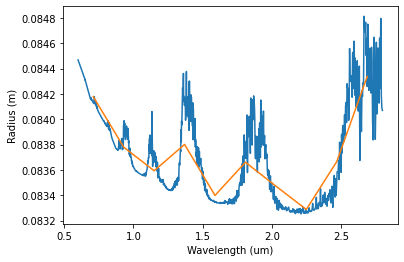

In [5]:
#read in spectrum 
psg_model=psg_class()
model_data=read_model(model_dir+'/'+model_name)

#get wavelength and transit depth info
psg_model.wavelength=np.array([float(d[0]) for d in model_data]) #wavelength in microns 
psg_model.Rp=np.array([d[1]*1000 for d in model_data]) #this is in m and is contribution of atmosphere
psg_model.Rp_err=np.array([d[2] for d in model_data]) 

plt.plot(psg_model.wavelength,(psg_model.Rp+Rp_m)/Rs_m)

bin_means1 = binned_statistic(psg_model.wavelength, psg_model.Rp, bins=10)
bin_means2 = binned_statistic(psg_model.wavelength, psg_model.Rp_err, bins=10)

bin_wave=[]
bin_rp=[]
bin_rp_err=[]
for i in range(10):
    bin_wave.append((bin_means1[1][i]+bin_means1[1][i+1])/2)
    bin_rp.append(bin_means1[0][i])
    bin_rp_err.append(bin_means2[0][i])
bin_wave=np.array(bin_wave)
bin_rp=np.array(bin_rp)
bin_rp_err=np.array(bin_rp_err)


psg_model.wavelength=bin_wave
psg_model.Rp=bin_rp
psg_model.Rp_err=bin_rp_err

plt.plot(psg_model.wavelength,(psg_model.Rp+Rp_m)/Rs_m)

print(psg_model.Rp)

plt.xlabel('Wavelength (um)')
plt.ylabel('Radius (m)')
plt.show()

In [6]:
#read in LD model
ld_model=read_model(specmodel)
ld_model_wv=np.array([d[0]/10000 for d in ld_model])

In [7]:
#Basic inputs to create the transit data
period=3.336649 #orbital period
b=0.40 #impact parameter
rhostar=2.91 #mean stellar density
rprs_noatmo=Rp_m/Rs_m #Rp/Rs with out atmosphere
tdur=0.0791 #transit duration in days

In [8]:
#Array to hold transit parameters
sol=np.zeros(18)
sol[0]=rhostar; 
sol[8]=2*tdur
sol[9]=period
sol[10]=0.40
obstime=np.arange(0,tdur*4,5/1440)
itime=np.ones(len(obstime))*5/1440

#list to store data.
photospectra=[]   #will contain all the observations

#Loop over atmosphere model
for i in range(len(psg_model.Rp)):
    sol[11]=(Rp_m+psg_model.Rp[i])/Rs_m
    print('rprs:',sol[11])
    
    #Get limb-darkening (simple closest approach)
    idx=find_nearest(ld_model_wv,psg_model.wavelength[i])

    sol[1]=ld_model[idx][1]*1
    sol[2]=ld_model[idx][2]*1
    sol[3]=ld_model[idx][3]*1
    sol[4]=ld_model[idx][4]*1

    model=tf.transitmodel(sol,obstime,itime=itime)
                          
    zpt=-(ld_model[idx][5])*np.pi*(42.0*ld_model[idx][1]+70.0*ld_model[idx][2]\
        +90.0*ld_model[idx][3]+105.0*ld_model[idx][4]-210.0)/210.0
    zpt=np.max([0.0,zpt])
                      
    model=model*zpt #add is spectral baseline
    noise=np.sqrt(model) #very rough noise
    model+=np.random.normal(noise*0,noise)
    
    phot=phot_class() #class for each wavelength
    phot.wavelength=np.copy(psg_model.wavelength[i])
    phot.time=np.copy(obstime)
    phot.flux=np.copy(model/zpt)
    phot.ferr=np.copy(noise/zpt)
    phot.itime=np.copy(itime)
    
    photospectra.append(phot)

rprs: 0.08417834615383925
rprs: 0.08377986757594456
rprs: 0.08359335364306769
rprs: 0.08380115263998153
rprs: 0.08339862669054252
rprs: 0.08366044552216657
rprs: 0.08347215579629033
rprs: 0.0832879578097081
rprs: 0.08366556103126134
rprs: 0.0843370801346142


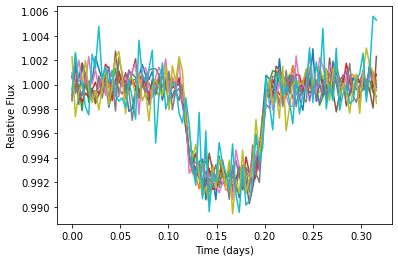

In [9]:
#Show a plot of the data.  Each colour is a different wavelength.

for p in photospectra:
    plt.plot(p.time,p.flux)#/np.median(p.flux))
    
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.show()

## Let's fit the multi-spectrum model

In [10]:
#number of planets to include
nplanet=1

#Set up default parameters 
tpars = sptransit_model_parameters([photospectra,nplanet])

#Fill in a few necessary parameters  
tpars.rhostar[0]=np.array([2.91])
tpars.rhostar[3]=np.array([1.0,3.0]) #search boundaries for nested sampling

tpars.period[0][0]=np.array([3.336649])
tpars.period[0][2]='fixed'

tpars.t0[0][0]=np.array([2*0.0791])
tpars.t0[0][3]=np.array([2*0.0791-0.01,2*0.0791+0.01])

tpars.rprs[0][0]=np.ones(len(photospectra))*0.0835
tpars.rprs[0][3]=np.array([0.082,0.086])

#Set search scale for zero-point (normalization)
#fmin=np.min(photospectra[0].flux)
#fmax=np.max(photospectra[0].flux)
#for p in photospectra:
#    fmin=np.min([fmin,np.min(p.flux)])
#    fmax=np.max([fmax,np.max(p.flux)])
#tpars.zeropoint[3]=np.array([fmin,fmax])
tpars.zeropoint[3]=np.array([0.998,1.002])

#Nested sampling wants names for parameters
clabels=['p','c1','c2','q1','q2','DIL','VOF','ZPT','EP','PE','BB','RD','EC','ES','KRV','TED','ELL','ALB',\
        'DSC','ASC','LSC']

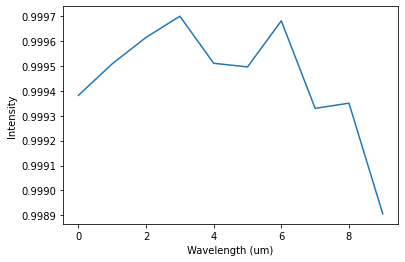

In [11]:
#Show the guess for the photometric zero-point -- this should match the out-of-transit levels.  
plt.plot(tpars.zeropoint[0])

plt.xlabel('Wavelength (um)')
plt.ylabel('Intensity')
plt.show()

In [32]:
def lnprob(x):
    ''' ln prob model
    Nested sampling and many MCMC routines use global variables.  Thus, only the fitted parameters are passed.
    Fitted parameters are contained in the input 'x' array.
    '''
    
    logl=1.0e0 #initialize log-likelihood to some value.
    #check validity of array
    badlpr=-np.inf #if outside bounds, then mark poor likelihood.
    
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    solnew=update_sol(tpars,x,sol) #contains sol but updated with values from 'x'
    
    #check validity of array
    logl=checksolution(tpars,solnew,badlpr)
    
    if logl>badlpr:
    
        for i in range(nwav):
            dscale=solnew[npars-3][i] #photometric scale
            ascale=solnew[npars-2][i] #photometric scale
            lscale=solnew[npars-1][i] #length scale for GP

            #check dscale, ascale and lscale hyper parameters (they must be positive)
            if (dscale <= 0.0)&(tpars.error_scale[2]=='fit'):
                logl=badlpr
            if (ascale <= 0.0)&(tpars.amplitude_scale[2]=='fit'):
                logl=badlpr
            if (lscale <= 0.0)&(tpars.length_scale[2]=='fit'):
                logl=badlpr

            if (tpars.amplitude_scale[2]=='fit')|(tpars.length_scale[2]=='fit'):
                modeltype=1 #GP model
            else:
                modeltype=0 #uncorrelated noise model

            npt=len(photospectra[i].time) #number of data points

            sol1=np.array([s[i] for s in solnew])

            #zpt=np.copy(sol1[7])
            sol1[7]-=1.0 

            if logl>badlpr: #check that we have a valid model to use
                #Retrieve transit model using sol3 array 
                ans = tf.transitmodel(sol1, photospectra[i].time, itime=photospectra[i].itime, \
                                       ntt=tpars.ntt, tobs=tpars.tobs, omc=tpars.omc)
                #ans = ans*zpt #put in zero-point

                if np.isnan(np.sum(ans))==False: #check for NaNs -- we don't want these.

                    if modeltype==0: #non-correlated noise-model
                        logl+=-0.5*(sum(np.log(photospectra[i].ferr*photospectra[i].ferr*dscale*dscale))\
                             +sum((photospectra[i].flux-ans)*(photospectra[i].flux-ans)/\
                                  (photospectra[i].ferr*photospectra[i].ferr*dscale*dscale)))
                else:
                    logl=badlpr

            #plt.plot(photospectra[i].time,photospectra[i].flux)
            #plt.plot(photospectra[i].time,ans)
            #plt.show()
            #Add Priors here...
    
            
    return logl

In [33]:
nwalkers=3 #number of walkers for MCMC
nsteps1 = 10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 100000
burninf=0.5 #burn-in for evalulating convergence
niter_cor=5000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.01 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer
itermax=5 #maximum iterations allowed.

sol=get_all_parameters(tpars,photospectra) #Creates internal array used to create transit model.
x=get_fitted_parameters(tpars)
tran_par_names=get_names(clabels,tpars)
beta=np.random.rand(len(x))*1.0e-6

In [34]:
corscale=betarescale(x,beta,niter_cor,burnin_cor,mhgmcmc,lnprob,imax=20)

Current Acceptance:  [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.98181818 0.98969072
 1.         0.98913043 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
Current Acceptance:  [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.95604396 0.94117647 0.95180723
 0.97222222 0.93877551 0.95698925 1.         0.98901099 0.97916667
 0.99029126 1.         0.98550725 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
Current Acceptance:  [1.         1.         1.         1.   

Current Acceptance:  [0.26666667 0.23529412 0.26744186 0.2745098  0.25       0.23170732
 0.25974026 0.26732673 0.25242718 0.2371134  0.26966292 0.25
 0.2        0.26262626 0.23       0.25531915 0.25842697 0.27272727
 0.26595745 0.23853211 0.23287671 0.24489796 0.23958333 0.26136364
 0.25       0.23913043 0.27272727 0.24742268 0.27835052 0.25
 0.27777778 0.23863636 0.26595745 0.23655914 0.2755102  0.34146341
 0.27777778 0.24050633 0.26595745 0.2278481  0.24675325 0.22988506
 0.25714286 0.23655914]
Current Acceptance:  [0.26666667 0.23529412 0.26744186 0.2745098  0.25       0.23170732
 0.25974026 0.26732673 0.25242718 0.2371134  0.26966292 0.25
 0.24468085 0.26262626 0.23       0.25531915 0.25842697 0.27272727
 0.26595745 0.23853211 0.23287671 0.24489796 0.23958333 0.26136364
 0.25       0.23913043 0.27272727 0.24742268 0.27835052 0.25
 0.27777778 0.23863636 0.26595745 0.23655914 0.2755102  0.27472527
 0.27777778 0.24050633 0.26595745 0.2278481  0.24675325 0.22988506
 0.25714286 0.236559

In [ ]:
nloop=0
nsteps=np.copy(nsteps1)
mcmcloop=True
while mcmcloop==True:

    nloop+=1 #count number of loops

    hchain1,haccept1=genchain(x,nsteps,beta*corscale,mhgmcmc,lnprob)
    hchain2,haccept2=genchain(x,nsteps,beta*corscale,mhgmcmc,lnprob)
    hchain3,haccept3=genchain(x,nsteps,beta*corscale,mhgmcmc,lnprob)

    if nloop==1:
        chain1=np.copy(hchain1)
        chain2=np.copy(hchain2)
        chain3=np.copy(hchain3)
        accept1=np.copy(haccept1)
        accept2=np.copy(haccept2)
        accept3=np.copy(haccept3)
    else:
        chain1=np.concatenate((chain1,hchain1))
        chain2=np.concatenate((chain2,hchain2))
        chain3=np.concatenate((chain3,hchain3))
        accept1=np.concatenate((accept1,haccept1))
        accept2=np.concatenate((accept2,haccept2))
        accept3=np.concatenate((accept3,haccept3))

    burnin=int(chain1.shape[0]*burninf)
    calcacrate(accept1,burnin)

    grtest=gelmanrubin(chain1,chain2,chain3,burnin=burnin,npt=len(phot.time))
    print('Gelman-Rubin Convergence:')
    print('parameter  Rc')
    for i in range(0,len(chain1[1,:])):
        print('%8s %3s %.4f' %(str(i),tran_par_names[i],grtest[i]))
    if int(np.sum(grtest[grtest<buf_converge_crit]/grtest[grtest<buf_converge_crit]))==len(grtest):
        mcmcloop=False
    else:
        mcmcloop=True
        nsteps+=nsteps1

    #runtest=np.array(tf.checkperT0(chain1,burninf,TPnthin,sol,serr))
    #print('runtest:',runtest)
    #if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))!=4.0:
    #    mcmcloop=False #run-away

    if nloop>=nloopmax: #break if too many loops
        mcmcloop=False

    #print("---- %s seconds ----" % (time.time() - start_time))

Global Acceptance Rate: 0.248
0 Acceptance Rate 0.216
1 Acceptance Rate 0.193
2 Acceptance Rate 0.217
3 Acceptance Rate 0.324
4 Acceptance Rate 0.295
5 Acceptance Rate 0.232
6 Acceptance Rate 0.204
7 Acceptance Rate 0.136
8 Acceptance Rate 0.148
9 Acceptance Rate 0.207
10 Acceptance Rate 0.234
11 Acceptance Rate 0.319
12 Acceptance Rate 0.311
13 Acceptance Rate 0.327
14 Acceptance Rate 0.233
15 Acceptance Rate 0.287
16 Acceptance Rate 0.340
17 Acceptance Rate 0.377
18 Acceptance Rate 0.248
19 Acceptance Rate 0.198
20 Acceptance Rate 0.314
21 Acceptance Rate 0.205
22 Acceptance Rate 0.274
23 Acceptance Rate 0.161
24 Acceptance Rate 0.232
25 Acceptance Rate 0.204
26 Acceptance Rate 0.322
27 Acceptance Rate 0.301
28 Acceptance Rate 0.226
29 Acceptance Rate 0.262
30 Acceptance Rate 0.252
31 Acceptance Rate 0.200
32 Acceptance Rate 0.206
33 Acceptance Rate 0.264
34 Acceptance Rate 0.392
35 Acceptance Rate 0.186
36 Acceptance Rate 0.252
37 Acceptance Rate 0.276
38 Acceptance Rate 0.189
39 Ac

In [ ]:
burnin=int(chain1.shape[0]*burninf)
chain=np.concatenate((chain1[burnin:,],chain2[burnin:,],chain3[burnin:,]))
accept=np.concatenate((accept1[burnin:,],accept2[burnin:,],accept3[burnin:,]))
burnin=int(chain.shape[0]*burninf)
calcacrate(accept,burnin)

plotchains(chain,burnin)

In [36]:
mcmcloop=True
nloop=0
nsteps=np.copy(nsteps2)
while mcmcloop==True:

    nloop+=1 #count number of loops

    burnin=int(chain1.shape[0]*burninf)
    buffer=np.concatenate((chain1[burnin:],chain2[burnin:],chain3[burnin:])) #create buffer for deMCMC
    x1=np.copy(chain1[chain1.shape[0]-1,:])
    x2=np.copy(chain1[chain1.shape[0]-1,:])
    x3=np.copy(chain1[chain1.shape[0]-1,:])
    corbeta=0.3
    burnin=int(chain1.shape[0]*burninf)
    chain1,accept1=genchain(x1,nsteps,beta*corscale,demhmcmc,lnprob,buffer=buffer,\
                            corbeta=corbeta,progress=True)
    chain2,accept2=genchain(x2,nsteps,beta*corscale,demhmcmc,lnprob,buffer=buffer,\
                            corbeta=corbeta,progress=True)
    chain3,accept3=genchain(x3,nsteps,beta*corscale,demhmcmc,lnprob,buffer=buffer,\
                            corbeta=corbeta,progress=True)

    burnin=int(chain1.shape[0]*burninf)
    grtest=gelmanrubin(chain1,chain2,chain3,burnin=burnin,npt=len(phot.time))
    print('Gelman-Rubin Convergence:')
    print('parameter  Rc')
    for i in range(0,len(chain1[1,:])):
        print('%8s %3s %.4f' %(str(i),tran_par_names[i],grtest[i]))

    if int(np.sum(grtest[grtest<converge_crit]/grtest[grtest<converge_crit]))==len(grtest):
        mcmcloop=False
    else:
        mcmcloop=True

    burnin=int(chain1.shape[0]*burninf)
    chain=np.concatenate((chain1[burnin:,],chain2[burnin:,],chain3[burnin:,]))
    accept=np.concatenate((accept1[burnin:,],accept2[burnin:,],accept3[burnin:,]))
    burnin=int(chain.shape[0]*burninf)
    calcacrate(accept,burnin)

    nsteps+=nsteps_inc #make longer chain to help with convergence

    ##check for run-away Chain.
    #runtest=np.array(tf.checkperT0(chain1,burninf,nthin,sol,serr))
    #print('runtest:',runtest)
    #if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))!=4.0:
    #    mcmcloop=False #run-away

    if nloop>=nloopmax: #break if too many loops
        mcmcloop=False

    #print("---- %s seconds ----" % (time.time() - start_time))

#print("done %s seconds ---" % (time.time() - start_time))


Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.0109
       1  q1 1.2443
       2  q1 1.1556
       3  q1 4.0765
       4  q1 2.5542
       5  q1 2.1828
       6  q1 1.2125
       7  q1 1.0757
       8  q1 2.0092
       9  q1 2.3316
      10  q1 2.2409
      11  q2 1.1769
      12  q2 1.4626
      13  q2 1.8817
      14  q2 1.8128
      15  q2 1.2356
      16  q2 3.7846
      17  q2 1.4236
      18  q2 2.2967
      19  q2 2.2214
      20  q2 1.2137
      21 ZPT 1.0253
      22 ZPT 1.0131
      23 ZPT 1.0208
      24 ZPT 1.0271
      25 ZPT 1.0130
      26 ZPT 1.0135
      27 ZPT 1.0114
      28 ZPT 1.0182
      29 ZPT 1.0109
      30 ZPT 1.0159
      31  EP 1.0310
      32  BB 1.0138
      33  RD 1.0259
      34  RD 1.0421
      35  RD 1.0278
      36  RD 1.0140
      37  RD 1.1425
      38  RD 1.3168
      39  RD 1.0552
      40  RD 1.0166
      41  RD 1.0126
      42  RD 1.0123
      43 DSC 1.0266
Global Acceptance Rate: 0.294
0 Acceptance Rate 0.133
1 Acceptance Rate 0.992
2


Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.0118
       1  q1 2.0156
       2  q1 4.2140
       3  q1 1.4984
       4  q1 1.6337
       5  q1 1.8378
       6  q1 2.1477
       7  q1 2.2490
       8  q1 1.1178
       9  q1 3.0406
      10  q1 2.2263
      11  q2 1.6770
      12  q2 1.6349
      13  q2 2.4031
      14  q2 1.9805
      15  q2 1.0355
      16  q2 1.5228
      17  q2 2.5105
      18  q2 3.6914
      19  q2 1.9231
      20  q2 5.1215
      21 ZPT 1.0110
      22 ZPT 1.0111
      23 ZPT 1.0125
      24 ZPT 1.0112
      25 ZPT 1.0111
      26 ZPT 1.0115
      27 ZPT 1.0113
      28 ZPT 1.0114
      29 ZPT 1.0113
      30 ZPT 1.0125
      31  EP 1.0119
      32  BB 1.0120
      33  RD 1.0120
      34  RD 1.0112
      35  RD 1.0109
      36  RD 1.0111
      37  RD 1.0112
      38  RD 1.0112
      39  RD 1.0119
      40  RD 1.0111
      41  RD 1.0117
      42  RD 1.0112
      43 DSC 1.0112
Global Acceptance Rate: 0.407
0 Acceptance Rate 0.110
1 Acceptance Rate 1.000
2


Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.0123
       1  q1 1.7156
       2  q1 2.6619
       3  q1 1.0944
       4  q1 1.2605
       5  q1 2.2902
       6  q1 2.4681
       7  q1 2.4563
       8  q1 2.2742
       9  q1 2.4390
      10  q1 1.8647
      11  q2 2.2039
      12  q2 3.2287
      13  q2 3.1991
      14  q2 3.2331
      15  q2 2.1469
      16  q2 2.3994
      17  q2 1.9195
      18  q2 2.0285
      19  q2 2.3723
      20  q2 2.9856
      21 ZPT 1.0111
      22 ZPT 1.0109
      23 ZPT 1.0114
      24 ZPT 1.0108
      25 ZPT 1.0108
      26 ZPT 1.0115
      27 ZPT 1.0108
      28 ZPT 1.0113
      29 ZPT 1.0114
      30 ZPT 1.0109
      31  EP 1.0121
      32  BB 1.0119
      33  RD 1.0109
      34  RD 1.0112
      35  RD 1.0114
      36  RD 1.0111
      37  RD 1.0111
      38  RD 1.0111
      39  RD 1.0111
      40  RD 1.0108
      41  RD 1.0120
      42  RD 1.0108
      43 DSC 1.0110
Global Acceptance Rate: 0.442
0 Acceptance Rate 0.123
1 Acceptance Rate 1.000
2

KeyboardInterrupt: 

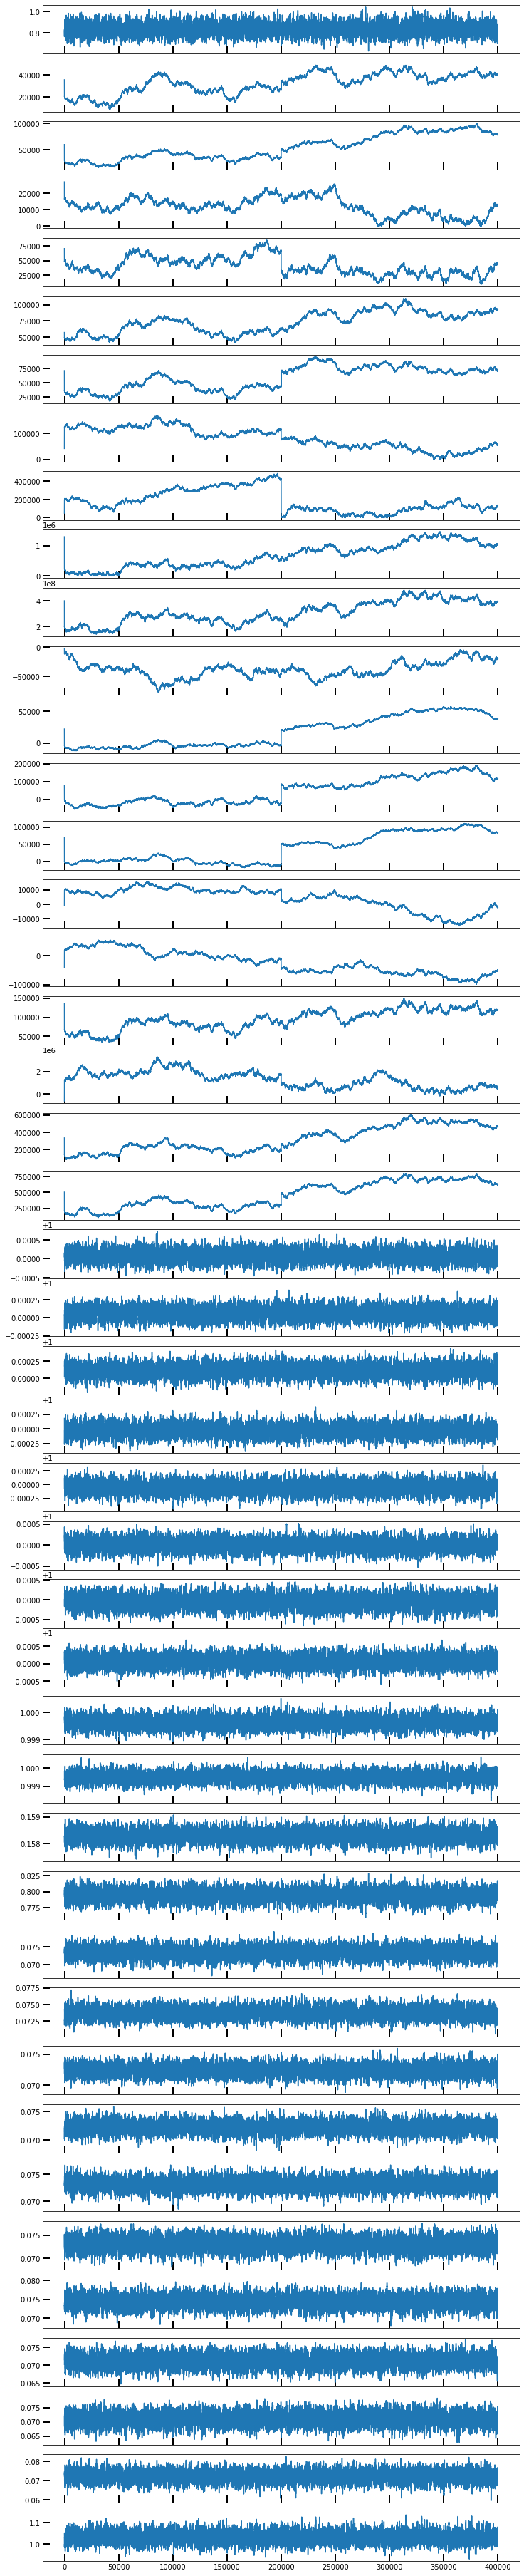

In [ ]:
plotchains(chain,burnin)
figure = corner.corner(chain[burnin::1,:],quantiles=[0.16, 0.5, 0.84],show_titles=True)